## Analyzing a movie

We are going to apply the different capabilities build in order to predict actors in a movie

### Importing libraries

In [ ]:
import sys
import os
import json
import pandas as pd
import numpy as np
!pip install pandasql
from pandasql import sqldf
import matplotlib.pyplot as plt
from time import time, strftime, localtime, gmtime, sleep
from random import randrange
import random
sys.path.append('/opt/workspace/src/python_scripts/')
from ops_face_recognition import train_recognizer,get_probabilities_for_folder
from ops_files_operations import read_pickle_file, read_json_file, get_element_from_metadata, create_pickle_file
from ops_face_detection import process_video, get_video_embeddings,get_frame_from_video, get_embeddings_from_image
from ops_results_interpretation import get_frames_df, get_actors_probs_query, get_predicted_timeline, get_summarized_timeline
from ops_logger import Logger
from IPython.display import clear_output
from IPython import display

### Processing movie

#### Obtaining movie embeddings

In [ ]:
movie_path = './datasets/videos/inception.mkv'
output_path = './models/embeddings/processed_videos'
get_video_embeddings(
    video_path = movie_path,
    results_path = output_path,
    partitions=32, 
    desired_fps=4
)

#### Defining paths

In [ ]:
movie_embeddings_path = './models/embeddings/processed_videos/inception'
processed_videos_metadata_path = './models/embeddings/processed_videos/inception/processed_videos_metadata.json'
results_folder = './models/results'
results_metadata_path = './models/results/probabilities_metadata.json'
recognizer_metadata_path = './models/recognizers/recognizer_metadata.json'
recognizer_path = './models/recognizers'

#### Getting processed_video_id and recognizer_id

In [ ]:
processed_video_id = get_element_from_metadata(
    metadata_file_path=processed_videos_metadata_path,
    latest=True
)["processed_video_id"]

recognizer_id = get_element_from_metadata(
    metadata_file_path=recognizer_metadata_path,
    latest=True
)["recognizer_id"]

#### Predicting results for movie

In [ ]:
folder_probabilities, folder_probabilities_metadata = get_probabilities_for_folder(
    folder_path = movie_embeddings_path,
    recognizer_folder = recognizer_path,
    save_to_pickle = True,
    output_folder = results_folder,
    processed_video_id = processed_video_id,
    recognizer_id = recognizer_id
)

#### Getting results_id and other metadata files

In [ ]:
results_metadata = get_element_from_metadata(
    metadata_file_path=results_metadata_path,
    #key = 'results_id',
    #value = results_id,
    latest=True
)

processed_videos_metadata = get_element_from_metadata(
    metadata_file_path=processed_videos_metadata_path,
    key = 'processed_video_id',
    value = results_metadata['processed_video_id']
)
recognizer_metadata = get_element_from_metadata(
    metadata_file_path=recognizer_metadata_path,
    key = 'recognizer_id',
    value = results_metadata['recognizer_id']
)

pickle_path = results_metadata['pickle_path']
results_id = results_metadata['results_id']
#results = read_pickle_file(pickle_path)

### Understanding results for all actors in a video

In [ ]:
summarized_timeline = get_summarized_timeline(
    results_id=results_id,
    processed_videos_metadata_path=processed_videos_metadata_path
)


In [ ]:
create_pickle_file(summarized_timeline,'./models/timelines/summarized_timeline.pickle')

In [ ]:
length_threshold = 24
sum_pred_value_threshold = 8
max_pred_value_threshold = 0.8

final_timeline = sqldf("""
    select *
    from full_timeline 
    where length >= {0} or sum_pred_value >= {1} or max_pred_value >= {2}
""".format(length_threshold,sum_pred_value_threshold,max_pred_value_threshold))

In [ ]:
create_pickle_file(timeline,'./models/timelines/inception_final_timeline_model1.pickle')

In [ ]:
sqldf("""

    with flags as (
    
        select
            *,
            
            true as is_base_model,
            
            case
                when length >= 12 or sum_pred_value >= 4 or max_pred_value >= 0.6 then true
                else false
            end as is_model_1,
            
            case
                when length >= 24 or sum_pred_value >= 8 or max_pred_value >= 0.8 then true
                else false
            end as is_model_2
            

        from full_timeline

    )
    
    select
        is_model_2,
        count(*)
    from flags
    group by 1
    
    
    
""")

#### Tester

In [ ]:
full_timeline = read_pickle_file('./models/timelines/summarized_timeline_flagged.pickle')
sqldf("""
    select *
    from full_timeline

""")

In [ ]:
num_of_test = 50
images_per_zone = 4
scene_path = './datasets/videos/inception.mkv'
full_timeline = read_pickle_file('./models/timelines/summarized_timeline_flagged.pickle')
model = 1

if model == 1:
    length_threshold = 12
    sum_pred_value_threshold = 4
    max_pred_value_threshold = 0.6
if model == 2:
    length_threshold = 24
    sum_pred_value_threshold = 8
    max_pred_value_threshold = 0.8

timeline = sqldf(f"""
    select
        *
    from full_timeline
    where
        (length >= {length_threshold} or sum_pred_value >= {sum_pred_value_threshold} or max_pred_value >= {max_pred_value_threshold})
        and user_validation is null

""")

results = []
available_records = int(timeline.shape[0])
if num_of_test <= available_records:
    sample_num = num_of_test
else:
    sample_num = available_records

prediction_nums = random.sample(range(available_records), sample_num)

for its, num in enumerate(prediction_nums):
    prediction = timeline.loc[[int(num)]]
    first_frame_num = int(prediction["frame_number_from"])
    last_frame_num = int(prediction["frame_number_to"])
    step = round((last_frame_num - first_frame_num)/images_per_zone)
    
    frames=[]
    counter = first_frame_num
    
    while counter < last_frame_num:
        frames.append(get_frame_from_video(video_path = scene_path,frame_number = counter))
        counter = counter + step
    
    f = plt.figure(figsize=[20,20])
    
    for it_num,frame in enumerate(frames):
        f.add_subplot(1,len(frames), it_num+1)        
        plt.imshow(frame[:,:,::-1])
        plt.title(f"Image {its+1}/{sample_num}, frame {first_frame_num + (step*(it_num))} ")
        plt.axis('off');
        
    plt.show()
    
    clear_output(wait=True)
    user_guess = input(f"Is {prediction['actor'].values[0]} in any this picture? (Frame ref: {first_frame_num}) (1 = Yes, 0 = No)")
    results.append(user_guess)
    full_timeline.loc[full_timeline["id"] == int(prediction["id"]),"user_validation"] = user_guess
    
hits = 0
for result in results:
    if int(result) == 1:
        hits = hits + 1

clear_output(wait=True)
create_pickle_file(full_timeline,'./models/timelines/summarized_timeline_flagged.pickle')
print(f'Total hits: {hits}. Accuracy: {(hits/sample_num)*100}%')

In [3]:
full_timeline = read_pickle_file('./models/timelines/summarized_timeline_flagged.pickle')

In [ ]:
sqldf("""
    select *
    from full_timeline
    where user_validation is not null

""")

In [4]:
sqldf("""
    select
        user_validation,
        count(*)
    from full_timeline
    where (length >= 12 or sum_pred_value >= 4 or max_pred_value >= 0.6)
    group by 1

""")

,user_validation,count(*)
0,0,356
1,1,186


In [92]:
acc_by_actor = sqldf("""

    with double_pred as (
    
        select
            frame_number_from,
            frame_number_to,
            count(*) as preds_in_interval
        from full_timeline
        group by 1,2
        having count(*) > 1
        order by count(*) desc
    
    ),
    
    dedup as (
    
        select
            full_timeline.*,

            coalesce(preds_in_interval,1) as preds_in_interval,

            rank() over(partition by frame_number_from,frame_number_to order by coalesce(user_validation,3) desc,sum_pred_value desc) as ranking

        from full_timeline
        left join double_pred using(frame_number_from,frame_number_to)
        --where preds_in_interval = 2
    
    ),
    
    base as (
    
        select * from dedup
        where ranking = 1 and (length >= 12 or sum_pred_value >= 4 or max_pred_value >= 0.6)
    
    ),
    
    kpi as (
    
        select
            *,
            count(*) over(order by sum_pred_value desc) as top_rank,
            cast(sum(user_validation) over(order by sum_pred_value desc) as float)/count(*) over(order by sum_pred_value desc) as kpi

        from base
        order by sum_pred_value desc
        
    )
    
    select
        actor,
        sum(user_validation) as total_hits,
        count(*) as total_zones,
        (cast(sum(user_validation) as float)/count(*))*100 as kpi
    from base 
    group by 1
    order by total_zones desc

""")

In [101]:
acc_by_actor.to_csv('test.csv')

Text(0, 0.5, 'Accuracy (in %)')

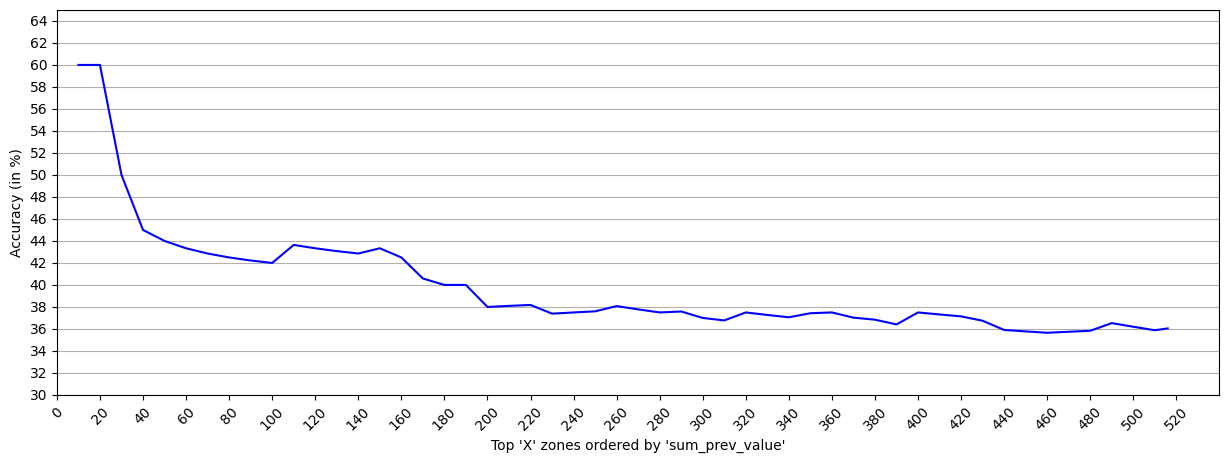

In [80]:
f = plt.figure()
f.set_figwidth(15)
f.set_figheight(5)
plt.plot(
        acc_by_rank_sum['top_rank'],
        acc_by_rank_sum['kpi']*100,
        #label = "overall pred",
        color = 'blue'
    )
plt.xlim(0,540) 
plt.ylim(30,65) 
plt.yticks(range(30, 65, 2))
plt.xticks(range(0, 540, 20))
plt.xticks(fontsize=10, rotation=45)
#plt.legend(loc='upper right')
plt.grid(axis = 'y' )
plt.xlabel("Top 'X' zones ordered by 'sum_prev_value'")
plt.ylabel("Accuracy (in %)")

In [ ]:
scene_path = './datasets/videos/inception.mkv'
frame = get_frame_from_video(video_path = scene_path,frame_number = 5930)#timestamp = '00:00:12.000')
embs, embs_metadata = get_embeddings_from_image(provided_image=frame, multiple_faces=True, display=True)

In [15]:
processed_videos_metadata = get_element_from_metadata(
    metadata_file_path='./models/embeddings/processed_videos/inception/processed_videos_metadata.json',
    latest=True
)